## Masked Autoencoders Saliency: Visualization Demo


### Prepare
Check environment. Install packages if in Colab.


In [105]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

from torchvision import datasets, transforms

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !git clone https://github.com/facebookresearch/mae.git
    sys.path.append('./mae2')
else:
    sys.path.append('..')

import models_mae

from importlib import reload # python 2.7 does not require this
import main_saliency
reload(main_saliency)
from main_saliency import Saliency_model

### Define utils (try playing with different mask_ratio values)

In [188]:
def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')

    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, target, model, include_target=True):
    transform = transforms.Compose([
        transforms.CenterCrop((400, 400)),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    img = transform(img)
    img = img.unsqueeze(dim=0)

    target = transform(target)
    target = target.unsqueeze(dim=0)

    with torch.no_grad():
        loss, pred = model(img, target, mask_ratio=0.5)
        predx = model.unpatchify2(pred)
        predx_np = predx.squeeze().cpu().numpy()
        predx_np_uint8 = (predx_np * 255).astype('uint8')
        predx_pil = Image.fromarray(predx_np_uint8)



    target_np = target.squeeze().cpu().numpy()
    target_np_uint8 = (target_np * 255).astype('uint8')
    target_pil = Image.fromarray(target_np_uint8)



    if(include_target):
        fig, axes = plt.subplots(1, 3, figsize=(10, 5))

        axes[0].imshow(img[-1].permute(1,2,0))
        axes[0].set_title('Original image')

        axes[1].imshow(target_pil)
        axes[1].set_title('Target')

        axes[2].imshow(predx_pil)
        axes[2].set_title('Predicted Image')
    else:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        axes[0].imshow(img[-1].permute(1,2,0))
        axes[0].set_title('Original image')

        axes[1].imshow(predx_pil)
        axes[1].set_title('Predicted Image')

    # Hide axes and display the plot
    for ax in axes:
        ax.axis('off')

    plt.tight_layout()
    plt.show()
    


### Load an image

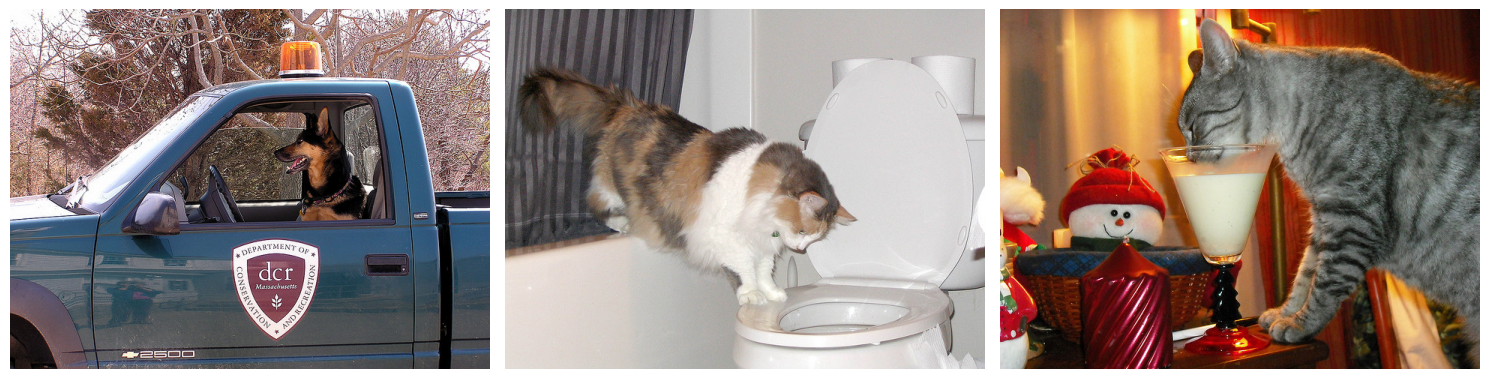

In [172]:
image_path = 'img.jpg'
target_path = 'target.png'
image = Image.open(image_path)
target = Image.open(target_path)

image_path2 = 'img2.jpg'
target_path2 = 'target2.png'
image2 = Image.open(image_path2)
target2 = Image.open(target_path2)

image_path3 = 'img3.jpg'
target_path3 = 'target3.png'
image3 = Image.open(image_path3)
target3 = Image.open(target_path3)



fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 2 columns

axs[0].imshow(image)
axs[0].axis('off')
axs[1].imshow(image2)
axs[1].axis('off')
axs[2].imshow(image3)
axs[2].axis('off')

plt.tight_layout()
plt.show()

### Load a pre-trained MAE saliency prediction model

In [137]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_base.pth
chkpt_dir = 'mae_visualize_vit_base.pth'
encoder = prepare_model(chkpt_dir, 'mae_vit_base_patch16')
print('Model loaded.')

model = main_saliency.Saliency_model(encoder.forward_encoder)

# You need to download the model_state.pth and put it in the demo directory. This is the checkpoint for the saliency model (trained with masking 0.5 masking ratio)
# https://drive.google.com/drive/folders/1VOJ16q3Iokqwo6OQZI1EHY5oGomWCc_d?usp=sharing

chkpt_dir_saliency_model = 'model_state.pth'
checkpoint = torch.load(chkpt_dir_saliency_model, map_location='cpu')
model_dict = model.state_dict()
checkpoint_filtered = {k: v for k, v in checkpoint.items() if k in model_dict}
model_dict.update(checkpoint_filtered)
model.load_state_dict(model_dict)



<All keys matched successfully>


<All keys matched successfully>

### Run MAE on the images

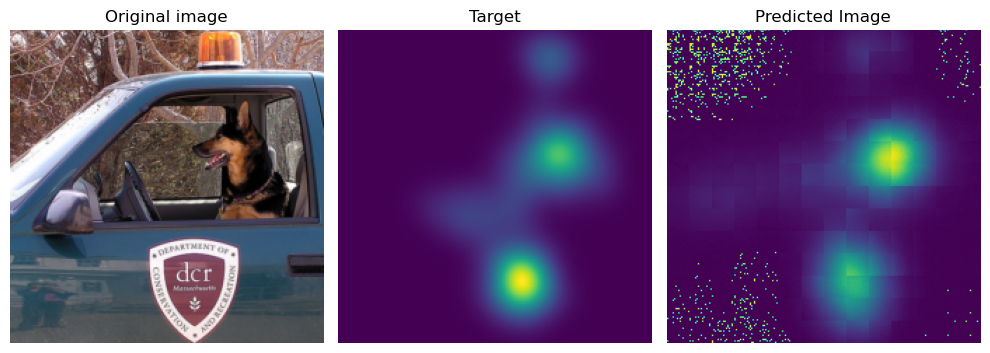

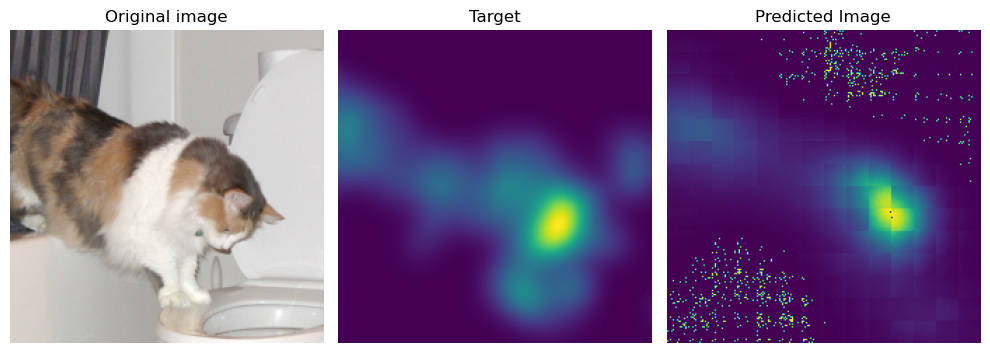

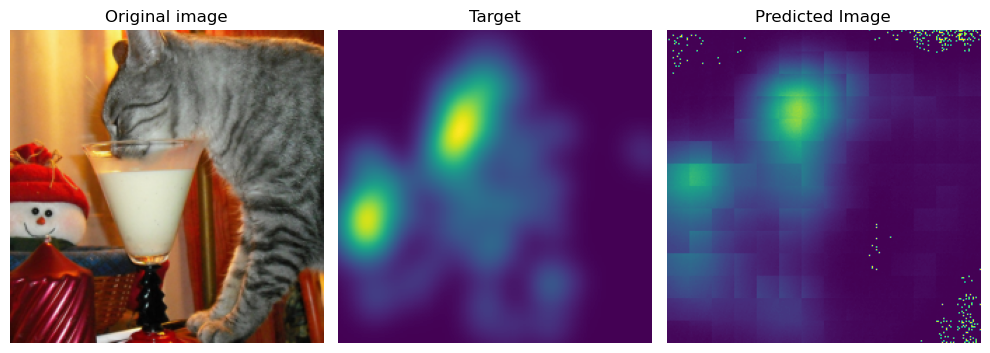

In [189]:
run_one_image(image, target, model)
run_one_image(image2, target2, model)
run_one_image(image3, target3, model)


### Own data (no target reference)

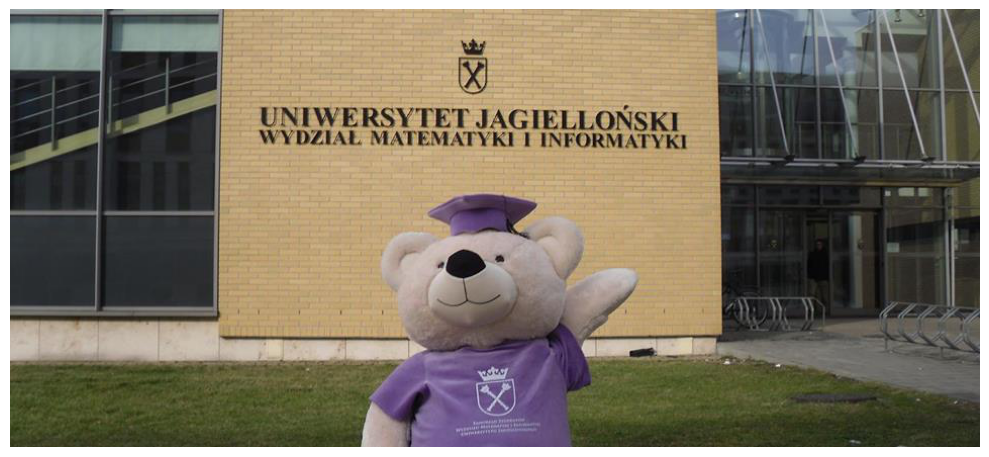

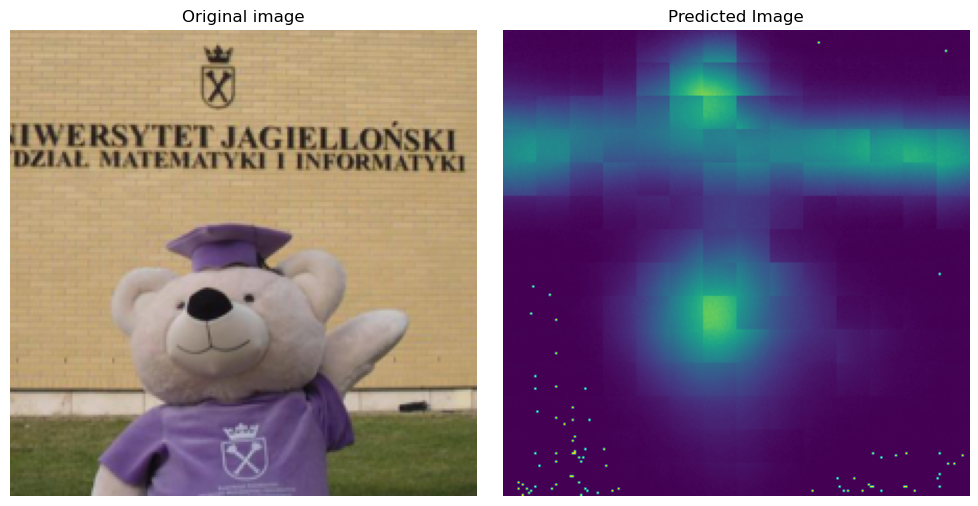

In [190]:
image_path4 = 'img4.jpg' #(https://www.facebook.com/WRSS.WMiI.UJ/)
image4 = Image.open(image_path4)

fig, axs = plt.subplots(1, 1, figsize=(10, 5))

axs.imshow(image4)
axs.axis('off')
plt.tight_layout()
plt.show()

run_one_image(image4, target, model, include_target=False)
